# Import

In [232]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [234]:
FILE_NAME = "PQ2MON - Orders - Weeks -1 to -109 (1).xls.xlsx"
DF = pd.read_excel(FILE_NAME)
DF.head(5)

,Client Grouping1,Customer Group,Requested Mode,Priority,Requested Trailer Class,Shipper Region3,Consignee Region3,Lane ID - City to City,Start Date,Completion Date,Order #,Avg. Weekly Frequency
0,Corporate,3M Canada Company,ROAD,Standard,DRY,ON2TOR,PQ2S,"MILTON,ON/ to DRUMMONDVILLE,PQ/",2019-04-16,2019-04-18,3790088,0
1,Corporate,3M Canada Company,ROAD,Standard,DRY,ON2TOR,PQ2S,"MILTON,ON/ to DRUMMONDVILLE,PQ/",2019-05-07,2019-05-09,3810953,0
2,Corporate,3M Canada Company,ROAD,Standard,DRY,ON2TOR,PQ2S,"MILTON,ON/ to DRUMMONDVILLE,PQ/",2019-06-07,2019-06-10,3841144,0
3,Corporate,3M Canada Company,ROAD,Standard,DRY,ON2TOR,PQ2S,"MILTON,ON/ to DRUMMONDVILLE,PQ/",2019-07-09,2019-07-11,3869973,0
4,Corporate,3M Canada Company,ROAD,Standard,DRY,PQ2MON,USMWIA,"STE THERESE,PQ/TE to PRAIRIE DU CHIEN,WI/",2020-02-26,2020-03-02,4066936,0


In [233]:
DAYS_0 = pd.Timedelta(days=0)
DAYS_1 = pd.Timedelta(days=1)
DAYS_14 = pd.Timedelta(days=14)

# Helper Functions

## Clean Data

In [235]:
def get_df_clean(df,drop=["Customer Group","Requested Mode","Order #","Avg. Weekly Frequency","Lane ID - City to City","Client Grouping1"]):
    df_PQ = df[df['Consignee Region3'].str.contains('PQ') | df['Shipper Region3'].str.contains('PQ')]
    df_clean = df_PQ.drop(columns=drop)
    return df_clean    

In [236]:
# Demo
DF_CLEAN = get_df_clean(DF)
DF_CLEAN

,Priority,Requested Trailer Class,Shipper Region3,Consignee Region3,Start Date,Completion Date
0,Standard,DRY,ON2TOR,PQ2S,2019-04-16,2019-04-18
1,Standard,DRY,ON2TOR,PQ2S,2019-05-07,2019-05-09
2,Standard,DRY,ON2TOR,PQ2S,2019-06-07,2019-06-10
3,Standard,DRY,ON2TOR,PQ2S,2019-07-09,2019-07-11
4,Standard,DRY,PQ2MON,USMWIA,2020-02-26,2020-03-02
...,...,...,...,...,...,...
23864,Standard,DRY,PQ2MON,BC2VAN,2020-06-18,2020-06-22
23865,Standard,REEFER,PQ2MON,ABNEDM,2020-02-12,2020-02-18
23866,Standard,REEFER,PQ2MON,ABNEDM,2020-02-12,2020-02-20
23867,Standard,REEFER,PQ2MON,ABNEDM,2020-02-13,2020-02-18


## Getting the statistics

In [237]:
# Get the counts for a schedule, such as inbound and out bound figures. Also calculates the imbalance levels
def get_df_count(df,start_date=None,end_date=None,fill_missing=True):    
    if start_date == None: start_date = df.loc[:,"Start Date":"Completion Date"].min().min() # This is not a mistake
    if end_date == None: end_date = df.loc[:,"Start Date":"Completion Date"].max().max() # This is not a mistake
    df_out = df[df['Shipper Region3'].str.contains('PQ')]['Start Date'].value_counts().sort_index(axis=0)
    df_in = df[df['Consignee Region3'].str.contains('PQ')]['Completion Date'].value_counts().sort_index(axis=0)
    df_count = pd.concat([df_out, df_in],axis=1).fillna(0, downcast='infer').rename(columns={"Start Date": "Outbound", "Completion Date": "Inbound"})
    if fill_missing:
        all_days  = [start_date + i*DAYS_1 for i in range((end_date-start_date).days+1)]
        df_count = pd.DataFrame(index=dates).join(df_count,how='outer').fillna(0)    
    df_count["Imbalance"] = df_count["Inbound"] - df_count["Outbound"]
    df_count["cImbalance"] = df_count["Imbalance"].cumsum()
    return df_count[start_date:end_date]

# Get the imbalance level of the date
def get_imb(df,date,col="Imbalance"):
    if col == "Imbalance" or col == "cImbalance":
        return df.loc[date,col]

In [238]:
#Demo
DF_COUNT = get_df_count(DF_CLEAN)
DF_COUNT

,Outbound,Inbound,Imbalance,cImbalance
2019-03-13,1.0,0.0,-1.0,-1.0
2019-03-14,0.0,0.0,0.0,-1.0
2019-03-15,0.0,0.0,0.0,-1.0
2019-03-16,0.0,0.0,0.0,-1.0
2019-03-17,0.0,0.0,0.0,-1.0
...,...,...,...,...
2021-04-20,21.0,20.0,-1.0,253.0
2021-04-21,12.0,25.0,13.0,266.0
2021-04-22,10.0,30.0,20.0,286.0
2021-04-23,11.0,24.0,13.0,299.0


In [239]:
#Demo
start_date = pd.Timestamp(2019,3,13,0)
end_date = pd.Timestamp(2019,3,19,0)

# df_count = get_df_count(DF_CLEAN,start_date,end_date)
df_count = get_df_count(DF_CLEAN,start_date,end_date,fill_missing=True)
print(get_imb(df_count,start_date))
df_count

-1.0


,Outbound,Inbound,Imbalance,cImbalance
2019-03-13,1.0,0.0,-1.0,-1.0
2019-03-14,0.0,0.0,0.0,-1.0
2019-03-15,0.0,0.0,0.0,-1.0
2019-03-16,0.0,0.0,0.0,-1.0
2019-03-17,0.0,0.0,0.0,-1.0
2019-03-18,0.0,0.0,0.0,-1.0
2019-03-19,2.0,0.0,-2.0,-3.0


In [240]:
# Get all the orders that start and/or completes on a specific day
def get_df_day(df,date,col=['Start Date','Completion Date']): 
    cond_out = df['Shipper Region3'].str.contains('PQ') & (df['Start Date'] == date)
    cond_in = df['Consignee Region3'].str.contains('PQ') & (df['Completion Date'] == date)
    if col == 'Start Date': return df[cond_out]
    elif col == 'Completion Date': return df[cond_in]
    elif col == ['Start Date','Completion Date']: return df[cond_out | cond_in]

# Get all orders that starts and/or completes in a specific time span
def get_df_span(df,start_date=None,end_date=None,col=['Start Date','Completion Date']):
    if start_date == None: start_date = df.loc[:,"Start Date":"Completion Date"].min().min() # This is not a mistake
    if end_date == None: end_date = df.loc[:,"Start Date":"Completion Date"].max().max() # This is not a mistake
    cond_out = df['Shipper Region3'].str.contains('PQ') & (df["Start Date"] >= start_date) & (df["Start Date"] <= end_date)
    cond_in = df['Consignee Region3'].str.contains('PQ') & (df["Completion Date"] >= start_date) & (df["Completion Date"] <= end_date)
    if col == 'Start Date': return df[cond_out]
    elif col == 'Completion Date': return df[cond_in]
    elif col == ['Start Date','Completion Date']: return df[cond_out | cond_in]

In [ ]:
# Aside: why I have to use .min().min()

In [307]:
df = DF_CLEAN
df.loc[:,"Start Date":"Completion Date"].min()

Start Date        2019-01-31
Completion Date   2019-03-24
dtype: datetime64[ns]

In [308]:
df.loc[:,"Start Date":"Completion Date"].min().min()

Timestamp('2019-01-31 00:00:00')

In [241]:
# Demo
df = DF_CLEAN
date1 = pd.Timestamp(2020,1,1,0)
date2 = pd.Timestamp(2020,1,7,0)

get_df_day(df,date2).sort_values(by=["Start Date","Completion Date"])
# get_df_day(df,date2,'Completion Date')
# get_df_day(df,date2,'Start Date')

,Priority,Requested Trailer Class,Shipper Region3,Consignee Region3,Start Date,Completion Date
14726,Standard,DRY,USMWMO,PQ2MON,2019-12-27,2020-01-07
4068,Standard,REEFER,USSWCS,PQ2MON,2019-12-31,2020-01-07
5490,Standard,HEATER,USSEE,PQ2QUE,2020-01-02,2020-01-07
13780,Expedited,DRY,ABSCAL,PQ2MON,2020-01-02,2020-01-07
14073,Standard,DRY,SK2SAS,PQ2S,2020-01-02,2020-01-07
58,Standard,DRY,USMNMI,PQ2S,2020-01-03,2020-01-07
10730,Standard,DRY,ON2TOR,PQ2MON,2020-01-05,2020-01-07
2148,Standard,HEATER,ON2TOR,PQ2MON,2020-01-06,2020-01-07
6210,Standard,DRY,ON2TOR,PQ2MON,2020-01-06,2020-01-07
7123,Standard,DRY,ON2TOR,PQ2MON,2020-01-06,2020-01-07


In [242]:
# Demo
df = DF_CLEAN
date1 = pd.Timestamp(2020,1,1,0)
date2 = pd.Timestamp(2020,1,7,0)

get_df_span(df,date1,date2)
# get_df_span(df,start_date=None,end_date=date2,how='inner')
# get_df_span(df,date1,date2,'inner')

,Priority,Requested Trailer Class,Shipper Region3,Consignee Region3,Start Date,Completion Date
15,Standard,DRY,PQ2OTT,PQ2MON,2019-12-30,2020-01-03
58,Standard,DRY,USMNMI,PQ2S,2020-01-03,2020-01-07
619,Standard,DRY,PQ2MON,USMEON,2020-01-06,2020-01-08
640,Standard,DRY,PQ2MON,USMEON,2020-01-03,2020-01-06
650,Standard,DRY,PQ2MON,USMEON,2020-01-06,2020-01-08
...,...,...,...,...,...,...
22182,Expedited,DRY,PQ2MON,ABNEDM,2020-01-04,2020-01-06
22183,Expedited,DRY,PQ2MON,ABNEDM,2020-01-06,2020-01-09
22821,Expedited,HEATER,PQ2MON,ABSCAL,2020-01-07,2020-01-09
22917,Expedited,HEATER,PQ2MON,MB2WIN,2020-01-03,2020-01-05


For get_cand_orders this is a function I wrote first so it might be a lil confusing. I will modify the code 
so that it is consistent with the get_bound_dates function later

Edit: Fixed

In [243]:
MIN_DEF, MAX_DEF = pd.Timedelta(days=0),pd.Timedelta(days=14)
          
# Get a number of orders that can be moved to other days
def get_cand_orders(df,date,col=['Start Date','Completion Date'],num_orders=None):
    df_cand = get_df_day(df,date,col)
    if num_orders == None: num_orders = len(df_cand)
    else: num_orders = int(min(len(df_cand),num_orders))
    return df_cand.iloc[:num_orders].sort_values(by=col)

In [244]:
# Demo
df = DF_CLEAN
date1 = pd.Timestamp(2020,1,1,0)
date2 = pd.Timestamp(2020,1,7,0)

# get_cand_orders(df,date2) # Get all the candidate orders
get_cand_orders(df,date2,'Start Date',num_orders=20) # Get a certain number of the candidate orders on that day

,Priority,Requested Trailer Class,Shipper Region3,Consignee Region3,Start Date,Completion Date
9770,Standard,DRY,PQ2S,USMEIS,2020-01-07,2020-01-09
13457,Expedited,DRY,PQ2MON,ABSCAL,2020-01-07,2020-01-09
13475,Expedited,HEATER,PQ2MON,ABSCAL,2020-01-07,2020-01-08
13735,Standard,DRY,PQ2S,MB2ONE,2020-01-07,2020-01-10
16546,Standard,DRY,PQ2MON,USEASW,2020-01-07,2020-01-10
17500,Expedited,DRY,PQ2MON,MB2WIN,2020-01-07,2020-01-08
19335,Standard,DRY,PQ2MON,USILCH,2020-01-07,2020-01-09
19336,Standard,DRY,PQ2MON,USILCH,2020-01-07,2020-01-09
19507,Standard,REEFER,PQ2MON,ABNEDM,2020-01-07,2020-01-13
20708,Standard,REEFER,PQ2MON,ON2N,2020-01-07,2020-01-08


In [245]:
# Actually reschedule an order in the scheduling table (by overwriting the date in column col)
# Returns the modified schedule and the updated counts
def move(df,index,to_date,col='Start Date'):
    df_resched = df.copy()
    df_resched.loc[index,col] = to_date
    return df_resched

In [246]:
# Demo
df = DF_CLEAN
index = df.index[5]
to_date = df.loc[index,'Start Date'] + DAYS_1

df_resched = move(df,index,to_date,'Start Date')
print(df.loc[index],'\n')
print(df_resched.loc[index])

Priority                              Standard
Requested Trailer Class                    DRY
Shipper Region3                         PQ2MON
Consignee Region3                       USMWIA
Start Date                 2020-04-08 00:00:00
Completion Date            2020-04-10 00:00:00
Name: 5, dtype: object 

Priority                              Standard
Requested Trailer Class                    DRY
Shipper Region3                         PQ2MON
Consignee Region3                       USMWIA
Start Date                 2020-04-09 00:00:00
Completion Date            2020-04-10 00:00:00
Name: 5, dtype: object


In [247]:
# Get the bound (earliest/latest) dates in between which an order have to start and complete.
# By default the assumption would be that the order must start in between 14 days prior to 
# originally scheduled all the way to 0 days before; and must completes within 1 day prior to 1 day after
# originally scheduled.
# Because of this, we based the completion date on the date in the ORIGINAL schedule (i.e DF_CLEAN)
def get_bound_dates(index):
    df = DF_CLEAN
    compl_date = df.loc[index,'Completion Date']
    e_start,l_start = compl_date - DAYS_14, compl_date - DAYS_0
    e_compl,l_compl = compl_date - DAYS_1, compl_date + DAYS_1
    return {"e_start":e_start,"l_start":l_start,"e_compl":e_compl,"l_compl":l_compl}

# Checks if an order violates any boundaries, especially after rescheduled
def check_bound_violations(df,index,check_start=True,check_compl=True):
    start = df.loc[index,'Start Date'] 
    compl = df.loc[index,'Completion Date']
    e_start,l_start,e_compl,l_compl = get_bound_dates(index).values()
    start_viol = check_start and (start < e_start or start > l_start)
    compl_viol = check_compl and (compl < e_compl or compl > l_compl)
    return start_viol or compl_viol

In [248]:
# Demo
df = DF_CLEAN
index = df.index[5]

print(df.loc[index,'Start Date':'Completion Date'],'\n')
print("Violation: ",check_bound_violations(df,index))
get_bound_dates(index)

Start Date         2020-04-08 00:00:00
Completion Date    2020-04-10 00:00:00
Name: 5, dtype: object 

Violation:  False


{'e_start': Timestamp('2020-03-27 00:00:00'),
 'l_start': Timestamp('2020-04-10 00:00:00'),
 'e_compl': Timestamp('2020-04-09 00:00:00'),
 'l_compl': Timestamp('2020-04-11 00:00:00')}

In [249]:
# Demo
df = DF_CLEAN
index = df.index[5]
to_date = df.loc[index,'Start Date'] + 3*DAYS_1

df_resched = move(df,index,to_date,'Start Date')
print(df.loc[index],'\n')
print(df_resched.loc[index])

print("Violation: ",check_bound_violations(df_resched,index))

Priority                              Standard
Requested Trailer Class                    DRY
Shipper Region3                         PQ2MON
Consignee Region3                       USMWIA
Start Date                 2020-04-08 00:00:00
Completion Date            2020-04-10 00:00:00
Name: 5, dtype: object 

Priority                              Standard
Requested Trailer Class                    DRY
Shipper Region3                         PQ2MON
Consignee Region3                       USMWIA
Start Date                 2020-04-11 00:00:00
Completion Date            2020-04-10 00:00:00
Name: 5, dtype: object
Violation:  True


In [250]:
# Get orders that have the same values in columns in col
# Used mostly to determine the shortest/longest expected time for order of the same type
def get_df_similar_orders(df,index,col=["Priority","Requested Trailer Class","Shipper Region3","Consignee Region3"]):
    order = df.loc[index,col]
    df_dup = df.loc[:,col]
    df_dup = df_dup[df_dup == order].dropna()
    return df.loc[df_dup.index,:]

In [251]:
# Demo
df = DF_CLEAN
index = df.index[5]

print(df.loc[index],'\n')
get_df_similar_orders(df,index)
# get_df_similar_orders(df,index,col=["Shipper Region3","Consignee Region3"]) # Only getting orders with same Shipper Region and Consignee Region

Priority                              Standard
Requested Trailer Class                    DRY
Shipper Region3                         PQ2MON
Consignee Region3                       USMWIA
Start Date                 2020-04-08 00:00:00
Completion Date            2020-04-10 00:00:00
Name: 5, dtype: object 



,Priority,Requested Trailer Class,Shipper Region3,Consignee Region3,Start Date,Completion Date
4,Standard,DRY,PQ2MON,USMWIA,2020-02-26,2020-03-02
5,Standard,DRY,PQ2MON,USMWIA,2020-04-08,2020-04-10
6,Standard,DRY,PQ2MON,USMWIA,2020-05-11,2020-05-13
7,Standard,DRY,PQ2MON,USMWIA,2020-12-01,2020-12-04
8,Standard,DRY,PQ2MON,USMWIA,2021-03-11,2021-03-14
9,Standard,DRY,PQ2MON,USMWIA,2021-03-17,2021-03-22
16075,Standard,DRY,PQ2MON,USMWIA,2019-12-03,2019-12-06
16076,Standard,DRY,PQ2MON,USMWIA,2019-12-18,2019-12-20
16077,Standard,DRY,PQ2MON,USMWIA,2019-12-29,2020-01-02
16078,Standard,DRY,PQ2MON,USMWIA,2020-01-13,2020-01-15


In [252]:
# Records the changes in days made to the "Start Date" and "Completion Date" of the original schedule
def get_df_sched_diff(df_sched,df_resched):
    df = df_resched.loc[:,"Start Date":"Completion Date"] - df_sched.loc[:,"Start Date":"Completion Date"]
    return df[df != DAYS_0].dropna(how='all').fillna(DAYS_0)

def get_df_count_diff(df_count,df_recount):
    df = df_recount.loc[:,:] - df_count.loc[:,:]
    return df[df != 0].dropna(how='all').fillna(0)

In [254]:
# Demo
date1 = pd.Timestamp(2021,1,1,0)

df = DF_CLEAN.copy()
index = df.index[5]
df_resched = move(df,index,date1,'Completion Date')

print(df.loc[index])
print(df_resched.loc[index])
get_df_sched_diff(df,df_resched)

Priority                              Standard
Requested Trailer Class                    DRY
Shipper Region3                         PQ2MON
Consignee Region3                       USMWIA
Start Date                 2020-04-08 00:00:00
Completion Date            2020-04-10 00:00:00
Name: 5, dtype: object
Priority                              Standard
Requested Trailer Class                    DRY
Shipper Region3                         PQ2MON
Consignee Region3                       USMWIA
Start Date                 2020-04-08 00:00:00
Completion Date            2021-01-01 00:00:00
Name: 5, dtype: object


,Start Date,Completion Date
5,0 days,266 days


In [255]:
date1 = pd.Timestamp(2021,1,1,0)

get_df_day(df_resched,date1)
# get_df_count(df_resched,date1,date1+DAYS_1)

# df_count[df_count != df_recount].dropna(how='all')

,Priority,Requested Trailer Class,Shipper Region3,Consignee Region3,Start Date,Completion Date
2695,Expedited,DRY,BC2VAN,PQ2MON,2020-12-29,2021-01-01
2696,Expedited,DRY,BC2VAN,PQ2MON,2020-12-30,2021-01-01
10173,Standard,DRY,PQ2MON,ABNEDM,2021-01-01,2021-01-07


In [256]:
get_df_count(df_resched,date1-3*DAYS_1,date1+3*DAYS_1)

,Outbound,Inbound,Imbalance,cImbalance
2020-12-29,18.0,17.0,-1.0,129.0
2020-12-30,21.0,18.0,-3.0,126.0
2020-12-31,15.0,23.0,8.0,134.0
2021-01-01,1.0,2.0,1.0,135.0
2021-01-02,12.0,10.0,-2.0,133.0
2021-01-03,8.0,3.0,-5.0,128.0
2021-01-04,20.0,23.0,3.0,131.0


# Algorithm

## Pseudo Code

Note:

    imb = inbound - outbound (how many spare trailers)  
    imb > 0 : there are spare trailers for the day (that can otherwise be utilized)    
    imb < 0 : there are shortage of trailers for the day (we likely have to hire outside trailers) 
    imb = 0 : there are just enough trailers 
    day.imb < next.imb : there are less spare trailers today than tomorrow/ or there are more of a shortage
    day.imb > next.imb : there are more spare trailers today than tomorrow/ or there are less of a shortage

Idea:
```
for date in all_days:
    next = day.next
    if (date.imb > 0): 
    # if we have spare trailers today
        if (next.imb > date.imb):
        # if tomorrow we have even more spare trailers than today
            #
            # We defer some outbound order today to tomorrow so we can utilize tomorrow's larger spare trailers        
            #
        elif (next.imb < date.imb):
        # if tomorrow there's less spare trailers, or even a shortage 
            #
            # We take in tomorrow outbound orders so we can utilize today's larger spare trailers
            #
            
    elif (date.imb < 0): 
    # if we are short of trailers today:
        if (next.imb > date.imb):
        # if we are less short of trailers tomorrow, or even have spare trailers
            #
            # We ask some inbound order to arrive sooner (today, as opposed to tomorrow)
            #
        elif (next.imb < date.imb):
        # if we are even more short of trailers tomorrow
            #
            # we allow some inbound order today to complete tomorrow
            #

```

## Code

In [268]:
def get_df_rescheduled(df,start_date=None,end_date=None):
    df_resched = get_df_span(df,start_date,end_date)
    df_recount = get_df_count(df,start_date,end_date,True)
    dates = df_recount.index
    
    for date in dates[:-1]:
        next_ = date + DAYS_1
        date_imb = get_imb(df_recount,date)
        next_imb = get_imb(df_recount,next_)
        
        if date_imb > 0:
            if date_imb < next_imb: # if there's more truck coming in tomorrow
                num_orders = int((next_imb - date_imb)/2)
                fr,to = date,next_

                cand = get_cand_orders(df_resched,fr,'Start Date',num_orders)
                for index in cand.index:
                    e_start,l_start,e_compl,l_compl = get_bound_dates(index).values()
                    if e_start <= to and to <= l_start:
                        df_resched = move(df_resched,index,to,col="Start Date")

            elif date_imb > next_imb:
                num_orders = int((date_imb - next_imb)/2)
                fr,to = next_,date

                cand = get_cand_orders(df_resched,fr,'Start Date',num_orders)
                for index in cand.index:
                    e_start,l_start,e_compl,l_compl = get_bound_dates(index).values()
                    if e_start <= to and to <= l_start:
                        df_resched = move(df_resched,index,to,col="Start Date")

        elif date_imb < 0: 
            if date_imb < next_imb: # if there's more truck coming in tomorrow
                num_orders = int((next_imb - date_imb)/2)
                fr,to = next_,date
                
                cand = get_cand_orders(df_resched,fr,'Completion Date',num_orders)
                for index in cand.index:
                    e_start,l_start,e_compl,l_compl = get_bound_dates(index).values()
                    if e_compl <= to and to <= l_compl:
                        df_resched = move(df_resched,index,to,col="Completion Date")

            elif date_imb > next_imb:
                num_orders = int((date_imb - next_imb)/2)
                fr,to = date,next_
                
                cand = get_cand_orders(df_resched,fr,'Completion Date',num_orders)
                for index in cand.index:
                    e_start,l_start,e_compl,l_compl = get_bound_dates(index).values()
                    if e_compl <= to and to <= l_compl:
                        df_resched = move(df_resched,index,to,col="Completion Date")
    return df_resched

In [278]:
start_date = pd.Timestamp(2020,1,1,0)
end_date = pd.Timestamp(2020,3,31,0)

df = DF_CLEAN
df_resched = get_df_rescheduled(df,start_date,end_date)
df_resched

,Priority,Requested Trailer Class,Shipper Region3,Consignee Region3,Start Date,Completion Date
4,Standard,DRY,PQ2MON,USMWIA,2020-02-26,2020-03-02
15,Standard,DRY,PQ2OTT,PQ2MON,2019-12-30,2020-01-04
16,Standard,DRY,PQ2OTT,PQ2MON,2020-02-17,2020-02-18
26,Standard,DRY,PQ2OTT,PQ2S,2020-01-13,2020-01-14
27,Standard,DRY,PQ2OTT,PQ2S,2020-01-20,2020-01-22
...,...,...,...,...,...,...
23833,Standard,DRY,PQ2MON,BC2VAN,2020-03-12,2020-03-19
23834,Standard,DRY,PQ2MON,USMEIS,2020-02-04,2020-02-06
23865,Standard,REEFER,PQ2MON,ABNEDM,2020-02-12,2020-02-18
23866,Standard,REEFER,PQ2MON,ABNEDM,2020-02-12,2020-02-20


In [279]:
df_sched = get_df_span(df,start_date,end_date)
df_sched

,Priority,Requested Trailer Class,Shipper Region3,Consignee Region3,Start Date,Completion Date
4,Standard,DRY,PQ2MON,USMWIA,2020-02-26,2020-03-02
15,Standard,DRY,PQ2OTT,PQ2MON,2019-12-30,2020-01-03
16,Standard,DRY,PQ2OTT,PQ2MON,2020-02-18,2020-02-19
26,Standard,DRY,PQ2OTT,PQ2S,2020-01-13,2020-01-15
27,Standard,DRY,PQ2OTT,PQ2S,2020-01-21,2020-01-22
...,...,...,...,...,...,...
23833,Standard,DRY,PQ2MON,BC2VAN,2020-03-12,2020-03-19
23834,Standard,DRY,PQ2MON,USMEIS,2020-02-04,2020-02-06
23865,Standard,REEFER,PQ2MON,ABNEDM,2020-02-12,2020-02-18
23866,Standard,REEFER,PQ2MON,ABNEDM,2020-02-12,2020-02-20


## Analysis and Correctness

Get the orders that were rescheduled, and how they were rescheduled

In [280]:
df_diff = get_df_sched_diff(df_sched,df_resched)
df_diff

,Start Date,Completion Date
15,0 days,1 days
16,-1 days,-1 days
26,0 days,-1 days
27,-1 days,0 days
28,-1 days,0 days
...,...,...
20815,-1 days,0 days
20935,-1 days,0 days
20969,-1 days,0 days
20970,-1 days,0 days


Before and After, side by side

In [301]:
df_sched.loc[df_diff.index].head(5)

,Priority,Requested Trailer Class,Shipper Region3,Consignee Region3,Start Date,Completion Date
15,Standard,DRY,PQ2OTT,PQ2MON,2019-12-30,2020-01-03
16,Standard,DRY,PQ2OTT,PQ2MON,2020-02-18,2020-02-19
26,Standard,DRY,PQ2OTT,PQ2S,2020-01-13,2020-01-15
27,Standard,DRY,PQ2OTT,PQ2S,2020-01-21,2020-01-22
28,Standard,DRY,PQ2OTT,PQ2S,2020-02-25,2020-02-27


In [300]:
df_resched.loc[df_diff.index].head(5)

,Priority,Requested Trailer Class,Shipper Region3,Consignee Region3,Start Date,Completion Date
15,Standard,DRY,PQ2OTT,PQ2MON,2019-12-30,2020-01-04
16,Standard,DRY,PQ2OTT,PQ2MON,2020-02-17,2020-02-18
26,Standard,DRY,PQ2OTT,PQ2S,2020-01-13,2020-01-14
27,Standard,DRY,PQ2OTT,PQ2S,2020-01-20,2020-01-22
28,Standard,DRY,PQ2OTT,PQ2S,2020-02-24,2020-02-27


Comparing the count of the old schedule vs the one for new schedule

In [299]:
df_count = get_df_count(df_sched)
df_count.head(5)

,Outbound,Inbound,Imbalance,cImbalance
2019-12-30,1.0,0.0,-1.0,-1.0
2020-01-01,3.0,0.0,-3.0,-4.0
2020-01-02,6.0,17.0,11.0,7.0
2020-01-03,18.0,14.0,-4.0,3.0
2020-01-04,7.0,1.0,-6.0,-3.0


In [298]:
df_recount = get_df_count(df_resched)
df_recount.head(5)

,Outbound,Inbound,Imbalance,cImbalance
2019-12-30,1.0,0.0,-1.0,-1.0
2020-01-01,3.0,7.0,4.0,3.0
2020-01-02,13.0,10.0,-3.0,0.0
2020-01-03,11.0,13.0,2.0,2.0
2020-01-04,7.0,2.0,-5.0,-3.0


The changes made comapred to the original table

In [297]:
get_df_count_diff(df_count,df_recount).head(5)

,Outbound,Inbound,Imbalance,cImbalance
2020-01-01,0.0,7.0,7.0,7.0
2020-01-02,7.0,-7.0,-14.0,-7.0
2020-01-03,-7.0,-1.0,6.0,-1.0
2020-01-04,0.0,1.0,1.0,0.0
2020-01-05,0.0,6.0,6.0,6.0


In [305]:
def plot_imb(df):
    firstDate = min(df.index)
    lastDate = max(df.index)
    plt.plot(df.index,df["Imbalance"],'o')
    plt.plot([firstDate,lastDate],[0,0],'k-')

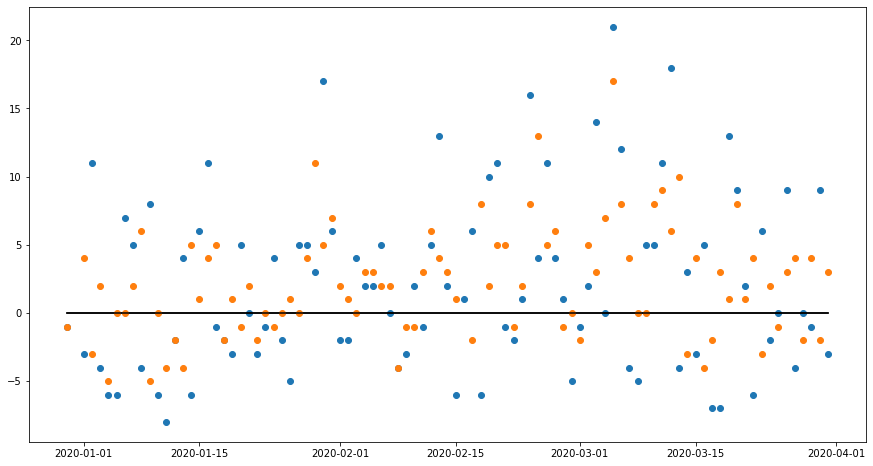

In [306]:
plt.figure(figsize=(15,8))
plot_imb(df_count)
plot_imb(df_recount)